## Evaluate behavior in eCommerce environments based on customer interactions

The aim of this work is to investigate customer habits based on metrics derived from the interaction characteristics of individual users. This approach will enable eCommerce stores to predict a user's expected monetary value and optimize their customer segmentation strategy.

This notebook presents an exploratory data analysis of a dataset consisting of a webshop's traffic. Based on that we engineered compound features more descriptive than the raw data.

### The dataset

The dataset used in our work contains user behavior events from a large online store. One row consists of 9 different features describing the event. To illustrate the sheer amount of data, there were over 42 million events captured in just one month, in October of 2019.

Further description of the dataset and download: 
https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store

In [1]:
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
%%writefile /root/.kaggle/kaggle.json

{"username":"KAGGLE_USER","key":"KAGGLE_KEY"}

Overwriting /root/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store --force
!unzip /content/ecommerce-behavior-data-from-multi-category-store.zip

100% 4.29G/4.29G [00:56<00:00, 59.7MB/s]
100% 4.29G/4.29G [00:56<00:00, 81.2MB/s]
Archive:  /content/ecommerce-behavior-data-from-multi-category-store.zip
replace 2019-Nov.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 2019-Oct.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
import pandas as pd

In [5]:
categorical_dtypes = {
    'event_type':'category', 'product_id':'category',
    'category_id':'category',
       'category_code':'category', 'brand':'category', 
    'user_id':'category', 'user_session':'category'
}

df = pd.read_csv('/content/2019-Oct.csv', dtype=categorical_dtypes)

In [6]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [7]:
df.shape

(42448764, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype   
---  ------         -----   
 0   event_time     object  
 1   event_type     category
 2   product_id     category
 3   category_id    category
 4   category_code  category
 5   brand          category
 6   price          float64 
 7   user_id        category
 8   user_session   category
dtypes: category(7), float64(1), object(1)
memory usage: 1.8+ GB


In [9]:
import matplotlib.pyplot as plt

In [11]:
import numpy as np

In [12]:
user_interactions = df['user_id'].value_counts()
ui_std = np.std(user_interactions)

# Ignoring outliers with extremely low or high number of interactions
user_interactions = user_interactions[(-3*ui_std < user_interactions) & (3*ui_std > user_interactions)]

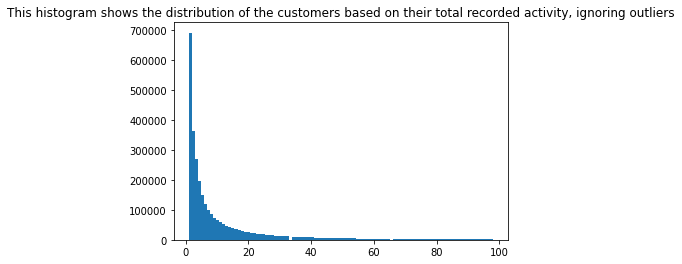

In [13]:
plt.title('This histogram shows the distribution of the customers based on their total recorded activity, ignoring outliers')
plt.hist(user_interactions, 100);

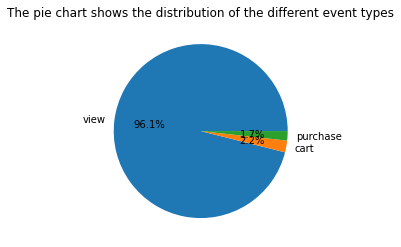

In [14]:
event_types = df['event_type'].value_counts()

plt.title('The pie chart shows the distribution of the different event types')
plt.pie(event_types, autopct='%1.1f%%', labels=['view', 'cart', 'purchase']);

### Feature engineering

Complex features were introduced from the initial dataset to capture nontrivial trends and implicit relationships hidden in the data. 
In this process, we considered several domain-specific approaches that might contribute to an improved understanding of customer characteristics.

One of those was the RFM, which is a widely used method for analyzing customer value. The central idea behind this to derive the recency, frequency, and monetary value of individual customers. 

To apply this methodology in this specific use case, we derived these three features not only for actual purchases but for all four types of user interactions: view, cart, remove from cart, purchases. This might be relevant for customer segmentation prior to purchase events.

It is important to note that there were no 'remove_from_cart' events present in the dataset from October of 2019.
To handle the enormous amounts of data and thus reduce the time required for training, data was aggregated by users. To model temporal relationships, the metrics were also derived for individual user sessions. 

For increased accuracy, along with the regular statistical descriptors we used regression models to describe the data characteristics.
Further feature selection steps with PCA and other techniques can be introduced to eliminate redundancy and correlated features. This, however, depends on the actual model choice and is therefore not possible in this phase.

In [5]:
import datetime
import numpy as np
from enum import IntEnum

def to_date(col):
  """Date and time of the events are recorded in the following format: 2020-10-25 22:52:42 UTC. The to_date function parses a DataFrame column from string to datetime.datetime object format."""
  return pd.to_datetime(col, format='%Y-%m-%d %H:%M:%S %Z')

def recency(curr_time, prev_time):
  """Recency is in minutes. The recency function takes 2 datetime.datetime arguments and calculates the difference in minutes if prev_time is a valid time. Both inputs are datetime.datetime objects."""
  return (curr_time - prev_time).seconds / 60 if prev_time is not pd.NaT else naT()

def naT():
  """Shorthand to creating NaT"""
  return pd.Timedelta('nan')

def regression_d(events, time_in_minutes, d):
  """Regression with polynomial of degree d of cumulated number of a DataFrame of event times in the given timeframe in minutes (at least 3 data points)"""
  if len(events) < 3:
    return [float('nan')] * (d + 1)
  time_window = datetime.timedelta(seconds=time_in_minutes*60)
  events.index = pd.to_datetime(events.index, unit='s')
  cumsum = events.resample(time_window).count().cumsum()
  values = pd.DataFrame([(i, cumsum[i]) for i in range(len(cumsum))])
  x = list(values[0])
  y = list(values[1])
  try:
    return np.polyfit(x, y, deg=d)
  except ValueError:
    return [float('nan')] * (d + 1)

def describe(events, time_in_minutes):
  """Mean and std of a DataFrame of event times in the given timeframe in minutes (at least 3 data points)."""
  if len(events) < 3:
    return [float('nan')] * 2
  time_window = datetime.timedelta(seconds=time_in_minutes*60)
  events.index = pd.to_datetime(events.index, unit='s')
  counts = events.resample(time_window).count()
  return counts.mean(), counts.std()

# Part of day enum definition
class PartOfDay(IntEnum):
  morning = 1
  day = 2
  evening = 3
  night = 4

def part_of_day(time):
  """4 major parts of the day are morning:6-12 day:12-18 evening:18-24 and night:0-6. The part_of_day function takes a datetime.datetime objects and determins the part of the day that time is in."""
  if 6 <= time.hour % 24 < 12:
    pod = PartOfDay.morning
  elif 12 <= time.hour % 24 < 18:
    pod = PartOfDay.day
  elif 18 <= time.hour % 24 < 24:
    pod = PartOfDay.evening
  elif 0 <= time.hour % 24 < 6:
    pod = PartOfDay.night
  else:
    pod = float('nan')
  return pod
  
def top_3_or_NaN(column):
  """Selects top 3 unique occurence of a DataFrame column. The top_3_or_NaN returns the top 3 object of the column and pads it with NaNs so the returned list is always of length 3"""
  top = list(column.value_counts().head(3).keys()) + [float('nan')] * 3
  return top[:3]

In [14]:
def extract_features_from_users_events(user_id, user_sessions):
  with open(f'/content/users.csv', 'a') as file:
    prev_event_time = naT()
    prev_cart_time = naT()
    prev_purchase_time = naT()
    absolute_first_event = naT()

    user_for_hours = 0
    user_view_num = 0
    user_cart_num = 0
    user_remove_num = 0
    user_purchase_num = 0
    user_purchase_monetary_value = 0

    sessions_features = []

    #for session_id, transactions in users_events.groupbusery('user_session', observed=True):
    for transactions in user_sessions:
      # get day of week for session
      event_times = to_date(transactions["event_time"])
      first_event = event_times.iloc[0]
      session_day_of_week = first_event.weekday()

      # Get part of day for session start
      session_part_of_day = part_of_day(first_event)

      # get session recency in minutes
      session_recency = recency(first_event, prev_event_time)
      prev_event_time = event_times.iloc[-1]

      # get session duration in minutes
      session_duration = recency(prev_event_time, first_event)

      # get absolute user time in days
      if absolute_first_event is pd.NaT:
        absolute_first_event = first_event
      user_for_hours = (prev_event_time - absolute_first_event).seconds / 3600

      # get events for specific event typespre
      views = transactions[transactions["event_type"] == "view"]
      carts = transactions[transactions["event_type"] == "cart"]
      removes = transactions[transactions["event_type"] == "remove_from_cart"]
      purchases = transactions[transactions["event_type"] == "purchase"]

      # get numbers of events by types
      session_view_num = len(views)
      session_cart_num = len(carts)
      session_remove_num = len(removes)
      session_purchase_num = len(purchases)

      # add session specific values to user values
      user_view_num += session_view_num
      user_cart_num += session_cart_num
      user_remove_num += session_remove_num
      user_purchase_num += session_purchase_num

      # get monetary value of events by types
      session_view_monetary_value = sum(views["price"])
      session_cart_monetary_value = sum(carts["price"])
      session_remove_monetary_value = sum(removes["price"])
      session_purchase_monetary_value = sum(purchases["price"])

      user_purchase_monetary_value += session_purchase_monetary_value

      # get cart and purchase recency
      session_cart_recency = recency(first_event, prev_cart_time)
      if not carts.empty:
        last_cart_time = list(carts.tail(1)["event_time"])[0]
        prev_cart_time = to_date(last_cart_time)

      session_purchase_recency = recency(first_event, prev_purchase_time)
      if not purchases.empty:
        last_purchase_time = list(purchases.tail(1)["event_time"])[0]
        prev_purchase_time = to_date(last_purchase_time)

      # get top 3 brands and product categories
      session_top_1_brand, session_top_2_brand, session_top_3_brand = top_3_or_NaN(transactions["brand"])
      session_top_1_category, session_top_2_category, session_top_3_category = top_3_or_NaN(transactions["category_id"])

      # get 1st, 2nd, 3rd polynomial regression of event times by types
      time_minutes = 5

      # View times
      session_view_1d_ax, session_view_1d_b = regression_d(views["event_time"], time_minutes, 1)
      session_view_2d_ax2, session_view_2d_bx, session_view_2d_c = regression_d(views["event_time"], time_minutes, 2)
      session_view_3d_ax3, session_view_3d_bx2, session_view_3d_cx, session_view_3d_d = regression_d(views["event_time"], time_minutes, 3)

      # Cart times
      session_cart_1d_ax, session_cart_1d_b = regression_d(carts["event_time"], time_minutes, 1)
      session_cart_2d_ax2, session_cart_2d_bx, session_cart_2d_c = regression_d(carts["event_time"], time_minutes, 2)
      session_cart_3d_ax3, session_cart_3d_bx2, session_cart_3d_cx, session_cart_3d_d = regression_d(carts["event_time"], time_minutes, 3)

      # Purchase times
      session_purchase_1d_ax, session_purchase_1d_b = regression_d(purchases["event_time"], time_minutes, 1)
      session_purchase_2d_ax2, session_purchase_2d_bx, session_purchase_2d_c = regression_d(purchases["event_time"], time_minutes, 2)
      session_purchase_3d_ax3, session_purchase_3d_bx2, session_purchase_3d_cx, session_purchase_3d_d = regression_d(purchases["event_time"], time_minutes, 3)

      # Event times together
      session_event_1d_ax, session_event_1d_b = regression_d(event_times, time_minutes, 1)
      session_event_2d_ax2, session_event_2d_bx, session_event_2d_c = regression_d(event_times, time_minutes, 2)
      session_event_3d_ax3, session_event_3d_bx2, session_event_3d_cx, session_event_3d_d = regression_d(event_times, time_minutes, 3)

      # Get basic descriptors of events by type
      time_minutes = 1
      session_view_mean, session_view_std = describe(views["event_time"], time_minutes)
      session_cart_mean, session_cart_std = describe(carts["event_time"], time_minutes)
      session_purchase_mean, session_purchase_std = describe(purchases["event_time"], time_minutes)
      session_remove_mean, session_remove_std = describe(removes["event_time"], time_minutes)

      features = {
        "first_event": first_event, # Time of the first event of the session
        "prev_event_time": prev_event_time, # Time of the last event of the session
        "session_duration": session_duration, # Elapsed time during the session in minutes
        "session_day_of_week": session_day_of_week, # On which day of the week did the session take place starting from 0: Monday
        "session_part_of_day": int(session_part_of_day), # On which part of the day did the session take place
        "session_recency": session_recency, # When was the last session in minutes
        "session_view_num": session_view_num, # How many view events happened during the session
        "session_cart_num": session_cart_num, # How many cart events happened during the session
        "session_remove_num": session_remove_num, # How many remove_from_cart events happened during the session
        "session_purchase_num": session_purchase_num, # How many purchase events happened during the session
        "session_view_monetary_value": session_view_monetary_value, # Sum of the monetary value of the view events happened during the session
        "session_cart_monetary_value": session_cart_monetary_value, # Sum of the monetary value of the cart events happened during the session
        "session_remove_monetary_value": session_remove_monetary_value, # Sum of the monetary value of the remove_from_cart events happened during the session
        "session_purchase_monetary_value": session_purchase_monetary_value, # Sum of the monetary value of the purchase events happened during the session
        "session_cart_recency": session_cart_recency, # When has the last cart event occured in minutes
        "session_purchase_recency": session_purchase_recency, # When has the last purchase event occured in minutes
        "session_top_1_brand": session_top_1_brand, # Most occuring brand in the session events
        "session_top_2_brand": session_top_2_brand, # 2nd most occuring brand in the session events
        "session_top_3_brand": session_top_3_brand, # 3rd most occuring brand in the session events
        "session_top_1_category": session_top_1_category, # Most occuring category in the session events
        "session_top_2_category": session_top_2_category, # 2nd most occuring category in the session events
        "session_top_3_category": session_top_3_category, # 3rd most occuring category in the session events
        "session_view_1d_ax": session_view_1d_ax, # Coefficients of the polynomial to fit the view, cart, purchase and remove_from_car events based on regression with polynomial of degree d
        "session_view_1d_b": session_view_1d_b,
        "session_view_2d_ax2": session_view_2d_ax2,
        "session_view_2d_bx": session_view_2d_bx,
        "session_view_2d_c": session_view_2d_c,
        "session_view_3d_ax3": session_view_3d_ax3,
        "session_view_3d_bx2": session_view_3d_bx2,
        "session_view_3d_cx": session_view_3d_cx,
        "session_view_3d_d": session_view_3d_d,
        "session_cart_1d_ax": session_cart_1d_ax,
        "session_cart_1d_b": session_cart_1d_b,
        "session_cart_2d_ax2": session_cart_2d_ax2,
        "session_cart_2d_bx": session_cart_2d_bx,
        "session_cart_2d_c": session_cart_2d_c,
        "session_cart_3d_ax3": session_cart_3d_ax3,
        "session_cart_3d_bx2": session_cart_3d_bx2,
        "session_cart_3d_cx": session_cart_3d_cx,
        "session_cart_3d_d": session_cart_3d_d,
        "session_purchase_1d_ax": session_purchase_1d_ax,
        "session_purchase_1d_b": session_purchase_1d_b,
        "session_purchase_2d_ax2": session_purchase_2d_ax2,
        "session_purchase_2d_bx": session_purchase_2d_bx,
        "session_purchase_2d_c": session_purchase_2d_c,
        "session_purchase_3d_ax3": session_purchase_3d_ax3,
        "session_purchase_3d_bx2": session_purchase_3d_bx2,
        "session_purchase_3d_cx": session_purchase_3d_cx,
        "session_purchase_3d_d": session_purchase_3d_d,
        "session_event_1d_ax": session_event_1d_ax, # Coefficients of the polynomial to fit all events occured based on regression with polynomial of degree d
        "session_event_1d_b": session_event_1d_b,
        "session_event_2d_ax2": session_event_2d_ax2,
        "session_event_2d_bx": session_event_2d_bx,
        "session_event_2d_c": session_event_2d_c,
        "session_event_3d_ax3": session_event_3d_ax3,
        "session_event_3d_bx2": session_event_3d_bx2,
        "session_event_3d_cx": session_event_3d_cx,
        "session_event_3d_d": session_event_3d_d,
        "session_view_mean": session_view_mean, # Basic descriptors of view, cart, purchase and remove_from_car events
        "session_view_std": session_view_std,
        "session_cart_mean": session_cart_mean,
        "session_cart_std": session_cart_std,
        "session_purchase_mean": session_purchase_mean,
        "session_purchase_std": session_purchase_std,
        "session_remove_mean": session_remove_mean,
        "session_remove_std": session_remove_std
      }

      sessions_features.append(features.values())

    user_view_frequency = (user_view_num / user_for_hours) if user_for_hours != 0 else float('nan')
    user_cart_frequency = (user_cart_num / user_for_hours) if user_for_hours != 0 else float('nan')
    user_remove_frequency = (user_remove_num / user_for_hours) if user_for_hours != 0 else float('nan')
    user_purchase_frequency = (user_purchase_num / user_for_hours) if user_for_hours != 0 else float('nan')
      
    user_features = [user_for_hours, 
                     user_purchase_monetary_value, 
                     user_view_num,
                     user_cart_num,
                     user_remove_num,
                     user_purchase_num,
                     user_view_frequency, 
                     user_cart_frequency, 
                     user_remove_frequency, 
                     user_purchase_frequency]

    file.write(','.join(
        [str(v) for v in user_features] + 
        [str(item) for sublist in sessions_features for item in sublist]) + '\n')
    

In [ ]:
# Set this to True for a faster run using a fraction of the dataset
dummy_run = False

if dummy_run:
  grouped = df.head(300000).groupby(['user_id', 'user_session'], observed=True)
else:
  grouped = df.groupby(['user_id', 'user_session'], observed=True)

In [ ]:
first = True
current_user = ''
user_sessions = []
processed_users = 0

for (user_id, session_id), session in grouped:
  if first:
    first = False
    current_user = user_id

  if current_user == user_id:
    user_sessions.append(session)
  else:
    extract_features_from_users_events(user_id, user_sessions)
    processed_users += 1

    print('processed users:', processed_users, '\tuser:', user_id, '\tnumber of sessions:', len(user_sessions))

    current_user = user_id 
    user_sessions = [session]

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!cp users.csv "/content/drive/My Drive"